In [ ]:
# !pip install lightly
# !pip install scikit-dimension

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as T

DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
SEED=42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(DEVICE)

cuda


In [26]:
# utils and metrics
from skdim.id import MLE # Maximum-Likelihood ID esimation

def model_param_count(model):
    return sum([np.prod(p.shape) for p in model.parameters()])

def plot_images(images, mean, std):
    denorm_transform = T.Normalize((-torch.tensor(mean) / torch.tensor(std)).tolist(), (1.0 / torch.tensor(std)).tolist())
    x = denorm_transform(images)
    x = torch.clip(x, 0., 1.)

    _, axs = plt.subplots(1, 10, figsize=(11, 5))
    for idx, ax in enumerate(axs):
        ax.imshow(x[idx].permute(1, 2, 0).numpy())
        ax.axis('off')
    plt.tight_layout()
    plt.show()


class MeanSquareDistancesStat:
    def __init__(self, ds_size, batch_size, n_epochs, hidden_dim):
        """
        ds_size: size of dataset
        batch_size: size of batch
        hidden_dim: dimension of representations
        """
        self.last_epoch_repr = torch.zeros(ds_size, hidden_dim,requires_grad=False)
        self.msd_hist = torch.zeros(n_epochs, ds_size, requires_grad=False)
        self.batch_size = batch_size
        
        self.n_samples = ds_size
        self.n_epochs = n_epochs
        
        self.cur_batch = 0
        self.cur_epoch = 0

    @torch.no_grad()
    def msd(self, x_prev, x_next):
        return torch.mean((x_next - x_prev) ** 2, dim=1)

    def push(self, x_enc_batch):
        if self.cur_epoch == self.n_epochs: raise ValueError('Statistics is already collected')
        
        l, r = self.cur_batch * self.batch_size, (self.cur_batch + 1) * self.batch_size
        
        x_repr_prev = self.last_epoch_repr[l:r]

        self.msd_hist[self.cur_epoch, l:r] = self.msd(x_repr_prev, x_enc_batch).cpu()
        
        self.last_epoch_repr[l:r] = x_enc_batch
        self.cur_batch += 1

    def inc_epoch(self):
        if self.cur_epoch == self.n_epochs: raise ValueError
        self.cur_epoch += 1
        self.cur_batch = 0
        

class IDStat:
    def __init__(self, ds_size:int, mle_kwargs):
        self.ds_size = ds_size
        self.id_hist = []

        self.mle_est = MLE(**mle_kwargs)

    def push(self, x_enc):
        """
        x_enc - all encoded representations from eval epoch
        """
        assert x_enc.shape[0] == self.ds_size
        if isinstance(torch.Tensor, x_enc):
            x_enc = x_enc.cpu().detach().numpy()
        self.id_hist.append(self.mle_est.fit_transform_pw(x_enc))


## Self-Supervised Contrastive Models

## Barlow Twins
https://arxiv.org/abs/2103.03230

In [4]:
from lightly.loss import BarlowTwinsLoss
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.transforms.byol_transform import (
    BYOLView1Transform,
    BYOLView2Transform,
    MultiViewTransform
)
from lightly.transforms.utils import IMAGENET_NORMALIZE

class BarlowTwins(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = BarlowTwinsProjectionHead(512, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

In [5]:
CHS = 3
IMG_SIZE = (32, 32)
BS = 128

class BYOLTransformWrapped(MultiViewTransform):
        """Appends BYOL transform output with not augmented images"""
        def __init__(self, view_1_transform, view_2_transform):
                view_1_transform = view_1_transform or BYOLView1Transform()
                view_2_transform = view_2_transform or BYOLView2Transform()
                transforms = [
                        T.Compose([T.ToTensor(), T.Normalize(mean=IMAGENET_NORMALIZE["mean"], std=IMAGENET_NORMALIZE["std"])]),
                        view_1_transform, 
                        view_2_transform
                ]
                super().__init__(transforms=transforms)


transform_train = BYOLTransformWrapped( # note: this thing works only with 3
        view_1_transform=BYOLView1Transform(input_size=IMG_SIZE[0], gaussian_blur=0.0),
        view_2_transform=BYOLView2Transform(input_size=IMG_SIZE[0], gaussian_blur=0.0),
)

transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_NORMALIZE["mean"], std=IMAGENET_NORMALIZE["std"])
])

ds_train = datasets.CIFAR10(root='../data', transform=transform_train, download=True)
ds_test = datasets.CIFAR10(root='../data', transform=transform_test, download=True)
train_loader = DataLoader(ds_train, batch_size=BS, shuffle=True, drop_last=True)
test_loader = DataLoader(ds_test, batch_size=BS, shuffle=False, drop_last=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
len(ds_train), next(iter(train_loader))[0][0].shape

(50000, torch.Size([128, 3, 32, 32]))

In [7]:
# backbone = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(CHS*np.prod(IMG_SIZE), 512),
#     nn.ELU(),
#     nn.Linear(512, 512),
#     nn.ELU()
# )

backbone = torchvision.models.vgg11().features 
print(model_param_count(backbone))

9220480


In [11]:
# MSD experiment
import gc

NUM_EPOCHS=10

model = BarlowTwins(backbone).to(DEVICE)
criterion = BarlowTwinsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
msd_tracker = MeanSquareDistancesStat(len(ds_test), BS, NUM_EPOCHS, hidden_dim=2048)

for epoch in range(NUM_EPOCHS):
    total_loss = 0
    model.train()
    for x, _ in tqdm(train_loader):
        _, x0, x1 = x
        x0 = x0.to(DEVICE)
        x1 = x1.to(DEVICE)

        z0 = model(x0)
        z1 = model(x1)

        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(train_loader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

    model.eval()
    with torch.no_grad():
        for x, _ in tqdm(test_loader):
            x = x.to(DEVICE)
            z = model(x)
            z = z.cpu()
            msd_tracker.push(z)
    msd_tracker.inc_epoch()

    torch.cuda.empty_cache()
    gc.collect()

    print(f"mean msd: {np.mean(msd_tracker.msd_hist[epoch].cpu().detach().numpy()):.3f}")


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [02:07<00:00,  3.07it/s]


epoch: 00, loss: 1159.23633


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.71it/s]


mean msd: 1.039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [02:03<00:00,  3.15it/s]


epoch: 01, loss: 995.71375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.59it/s]


mean msd: 1.410


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [02:12<00:00,  2.94it/s]


epoch: 02, loss: 924.70300


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 16.10it/s]


mean msd: 1.124


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [02:07<00:00,  3.06it/s]


epoch: 03, loss: 868.74677


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 16.08it/s]


mean msd: 1.320


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [02:23<00:00,  2.71it/s]


epoch: 04, loss: 822.38269


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.24it/s]


mean msd: 1.158


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [02:00<00:00,  3.23it/s]


epoch: 05, loss: 788.80988


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 16.02it/s]


mean msd: 1.223


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [02:02<00:00,  3.19it/s]


epoch: 06, loss: 759.75684


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.01it/s]


mean msd: 1.828


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [02:17<00:00,  2.83it/s]


epoch: 07, loss: 733.88184


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.37it/s]


mean msd: 1.608


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [02:24<00:00,  2.69it/s]


epoch: 08, loss: 712.45825


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.03it/s]


mean msd: 1.388


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [02:13<00:00,  2.92it/s]


epoch: 09, loss: 702.99017


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.27it/s]


mean msd: 1.384


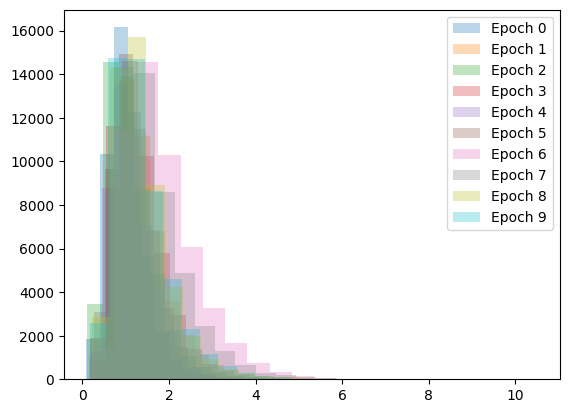

In [13]:
# histogram plot of mdp on first and last epochs
msd_hist = np.array(msd_tracker.msd_hist[:NUM_EPOCHS])
for ep in range(NUM_EPOCHS):
    plt.hist(msd_hist[ep, :], bins=20, alpha=0.3, label=f'Epoch {ep}')
plt.legend()
plt.show()

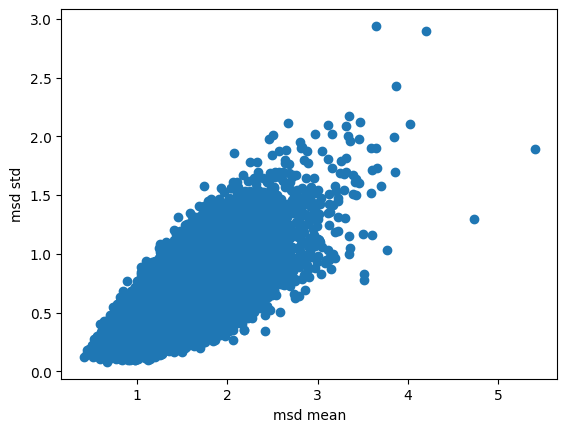

In [14]:
# mean and std of each sample msd
msd_means = msd_hist.mean(axis=0)
msd_stds = msd_hist.std(axis=0)

# plot scatter plot
plt.scatter(msd_means, msd_stds)
plt.xlabel('msd mean')
plt.ylabel('msd std')
plt.show()

In [24]:
np.argsort(msd_means)[-10:]

array([ 7784,  4273,  7635, 35042, 25455, 10151, 21305, 20949, 10589,
       13497])

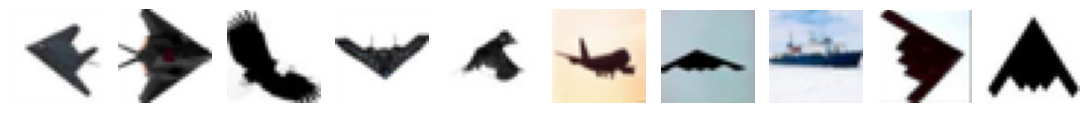

In [38]:
# images with maximum mean msd
imgs = torch.cat([ds_test[idx][0].reshape(1, 3, 32, 32) for idx in np.argsort(msd_means)[-10:]])
plot_images(imgs, IMAGENET_NORMALIZE["mean"], IMAGENET_NORMALIZE["std"]) 

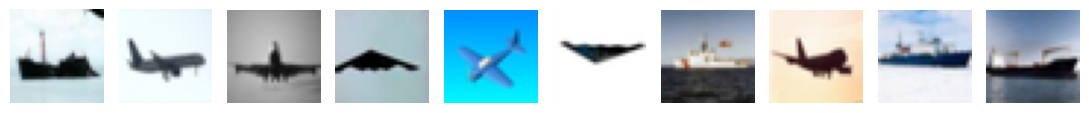

In [39]:
# images with max mean std of msd
imgs = torch.cat([ds_test[idx][0].reshape(1, 3, 32, 32) for idx in np.argsort(msd_stds)[-10:]])
plot_images(imgs, IMAGENET_NORMALIZE["mean"], IMAGENET_NORMALIZE["std"]) 

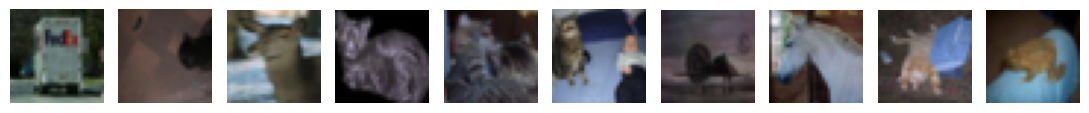

In [41]:
imgs = torch.cat([ds_test[idx][0].reshape(1, 3, 32, 32) for idx in np.argsort(msd_means)[:10]])
plot_images(imgs, IMAGENET_NORMALIZE["mean"], IMAGENET_NORMALIZE["std"]) 

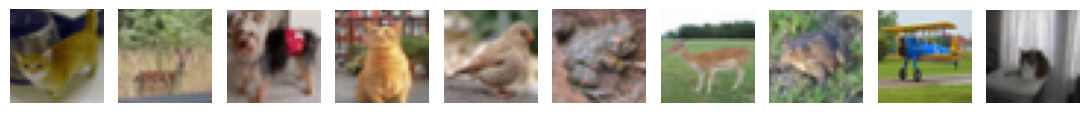

In [42]:
imgs = torch.cat([ds_test[idx][0].reshape(1, 3, 32, 32) for idx in np.argsort(msd_stds)[:10]])
plot_images(imgs, IMAGENET_NORMALIZE["mean"], IMAGENET_NORMALIZE["std"]) 